# Goal 

This goal of this assignement was to determine similar movies to recommend using the other ratings and tags. The were data sets provided split. The first task was the merge the data sets to have one dataframe that included `title`, `rating`, and `movieId`. In the notebook `feature_engineering_tags` I reconstructed the `tag` feature to be able to reason about it. In this notebook, I assigned an `polarity` to the tag and merged the polarity with the dataframe. I thought this could help combine movies of similar style of tags without having to vectorize the tag. 

I then created a cluster of `polarity` vs `tag`. I created a `KMeans` function to fit the data and used the elbow method to detmine how many clusters were needed for K-Means. The number of clusters was 10. 

I relabed the cluster wiht the movie it matches and created a function that produces movies from the same cluster when asked for a recommendation. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
# nltk.download('stopwords')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re
import string
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn import metrics
from sklearn.cluster import KMeans
import random

In [2]:
movies = pd.read_csv('~/Documents/EECS/EECS_731/HW/EECS731_3/notebooks/tag_trimmed_2.csv')

In [3]:
moives = movies.drop(columns='Unnamed: 0')

In [4]:
from textblob import TextBlob
movies[['polarity', 'subjectivity']] = movies['tag'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [5]:
movies_rp = movies.loc[:, movies.columns.intersection(['movieId','rating','polarity'])]
movies_rpt = movies.loc[:, movies.columns.intersection(['movieId','title','rating','polarity'])]
movies_rpt.set_index('movieId', inplace=True)
# movies_rpt = movies_rpt['polarity'].round(1)
movies_rpt

,title,rating,polarity
movieId,,,
1,Toy Story (1995),3.920930,0.30
2,Jumanji (1995),3.431818,-0.10
3,Grumpier Old Men (1995),3.259615,0.10
5,Father of the Bride Part II (1995),3.071429,0.00
7,Sabrina (1995),3.185185,0.00
...,...,...,...
183611,Game Night (2018),4.000000,0.25
184471,Tomb Raider (2018),2.500000,-0.40
187593,Deadpool 2 (2018),3.875000,0.00


In [6]:
movies_rpt['polarity'] = movies_rpt['polarity'] + 1
movies_rpt

,title,rating,polarity
movieId,,,
1,Toy Story (1995),3.920930,1.30
2,Jumanji (1995),3.431818,0.90
3,Grumpier Old Men (1995),3.259615,1.10
5,Father of the Bride Part II (1995),3.071429,1.00
7,Sabrina (1995),3.185185,1.00
...,...,...,...
183611,Game Night (2018),4.000000,1.25
184471,Tomb Raider (2018),2.500000,0.60
187593,Deadpool 2 (2018),3.875000,1.00


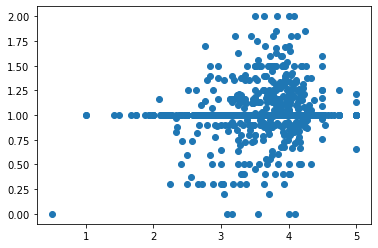

In [7]:
plt.scatter(movies_rpt['rating'], movies_rpt['polarity'])

In [8]:
X_rp = movies_rpt[['rating', 'polarity']].values
X_rp
# x_rp is a ndarray 

array([[3.92093023, 1.3       ],
       [3.43181818, 0.9       ],
       [3.25961538, 1.1       ],
       ...,
       [3.875     , 1.        ],
       [3.9       , 1.        ],
       [3.5       , 1.        ]])

In [9]:
kmeans_rp = KMeans(n_clusters=5)
predictions=kmeans_rp.fit_predict(X_rp)

In [10]:
def draw_clusters(movies_rpt, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('rating')
    ax.set_ylabel('polarity')

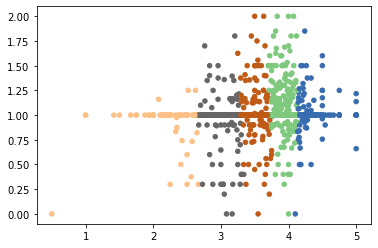

In [11]:
clustered = pd.concat([movies_rpt.reset_index(), pd.DataFrame({'group':predictions})], axis=1) 
plt.scatter(clustered['rating'], clustered['polarity'], c=clustered['group'], s=20, cmap='Accent')

Next, I used the elbow method to find the optimal number of clusters. 

I found the steps to do so at https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

In [12]:
# must download yellowbrick
from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

/Users/annarosefritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
visualizer = KElbowVisualizer(
    kmeans_rp, k=(4,25)
    #metric='calinski_harabasz', timings=False, locate_elbow=False
)

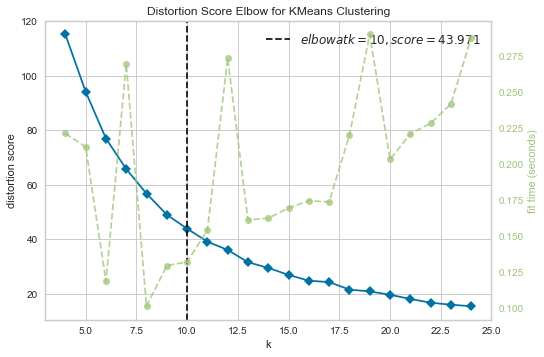

In [14]:
visualizer.fit(X_rp)
visualizer.show()

It appeared that the best K for this problem is K = 10. 

In [15]:
kmeans_rp_2 = KMeans(n_clusters=10)
model = kmeans_rp_2.fit_predict(X_rp)
model2 = kmeans_rp_2.fit(X_rp)

For some reason, the cluster graph only works with the function `fit_predict` and then later, the `recommend` function only works with the `fit` function. 

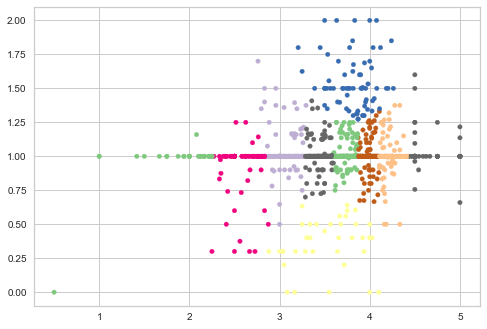

In [16]:
clustered = pd.concat([movies_rpt.reset_index(), pd.DataFrame({'group':model})], axis=1) 
plt.scatter(clustered['rating'], clustered['polarity'], c=clustered['group'], s=20, cmap='Accent')

## Finding movie cluster belongs 

In order to predict similar movies, we need to relate the cluster to the title. `movie_rpt` is the original data frame. We take each index and row (so every element) and pass it through the model. To the row I appended the title. 

Now, we have the titles sorted by where they cluster element was. 

In [17]:
model2.labels_

array([4, 7, 7, ..., 2, 2, 7], dtype=int32)

Here, I could see which elements belong in each cluster, but it doesn't give me the title. 

I found how to do this here: https://stackoverflow.com/questions/32232067/cluster-points-after-kmeans-clustering-scikit-learn

In [18]:
n_clusters = 10
labels_num = {i: np.where(model2.labels_ == i)[0] for i in range(model2.n_clusters)}
labels_num

{0: array([   5,    6,    8,   11,   18,   22,   30,   33,   42,   45,   52,
          53,   54,   57,   62,   68,   86,   90,   91,  102,  108,  113,
         116,  118,  120,  122,  129,  142,  144,  147,  148,  165,  173,
         184,  185,  194,  198,  202,  212,  217,  221,  223,  225,  231,
         266,  271,  272,  280,  281,  283,  284,  304,  327,  329,  334,
         346,  349,  353,  354,  356,  361,  362,  366,  371,  377,  384,
         389,  397,  401,  403,  404,  414,  416,  418,  420,  422,  423,
         424,  434,  450,  451,  457,  458,  463,  466,  467,  468,  469,
         480,  485,  491,  492,  497,  503,  504,  506,  528,  529,  534,
         535,  541,  548,  551,  561,  563,  566,  572,  579,  587,  593,
         603,  615,  616,  623,  626,  632,  640,  644,  648,  650,  651,
         659,  660,  662,  667,  668,  671,  680,  695,  698,  704,  711,
         715,  718,  723,  724,  729,  731,  732,  733,  740,  743,  746,
         747,  753,  757,  762,  76

With this, I saw that some clusters have way more values than others. So, it's not a great model. 

I couldn't figure out how to map the values to the titles so I used a different way instead. 

This function uses `title` rather than numbers. 

In [19]:
movie_to_cluster = [[] for i in range(10)]

for x, y in movies_rpt.iterrows():
    model_input = y[['rating','polarity']].to_numpy().reshape(1,-1)
    point = model2.predict(model_input)[0]
    movie_to_cluster[point].append(y['title'])

In [20]:
movie_to_cluster

[['American President, The (1995)',
  'Nixon (1995)',
  'Sense and Sensibility (1995)',
  'Leaving Las Vegas (1995)',
  'Dead Man Walking (1995)',
  'Richard III (1995)',
  "Mr. Holland's Opus (1995)",
  'Bottle Rocket (1996)',
  'Apollo 13 (1995)',
  'Crimson Tide (1995)',
  'Circle of Friends (1995)',
  'Clerks (1994)',
  'Don Juan DeMarco (1995)',
  'Ed Wood (1994)',
  'Immortal Beloved (1994)',
  'Madness of King George, The (1994)',
  "What's Eating Gilbert Grape (1993)",
  'Adventures of Priscilla, Queen of the Desert, The (1994)',
  'Clear and Present Danger (1994)',
  'When a Man Loves a Woman (1994)',
  "Carlito's Way (1993)",
  'In the Line of Fire (1993)',
  'Jurassic Park (1993)',
  'Much Ado About Nothing (1993)',
  'Philadelphia (1993)',
  'Remains of the Day, The (1993)',
  'Shadowlands (1993)',
  'Aladdin (1992)',
  'Dances with Wolves (1990)',
  'Snow White and the Seven Dwarfs (1937)',
  'Beauty and the Beast (1991)',
  'Rock, The (1996)',
  'Time to Kill, A (1996)',


## Making recommendenations 

Below is a sample for how to use the `predict` function. 

In [21]:
Y = [[1,1]]
Y2 = model2.predict(Y)
Y2

array([5], dtype=int32)

The `recommend` function recommends a movie. It take the movie you provide, and give back a movie that is in that same cluster. It randomly selects movies from the cluster with the `random` function. 

In [22]:
def recommend(input): 
    # here we find the row the movie is at 
    movie_row = movies_rpt.loc[movies_rpt.title == input]
    # then we need the parameter from that row to predict 
    model_input = movie_row[['rating', 'polarity']]
    cluster = model2.predict(model_input)[0]  
    #randomly recommend something from that sample 
    print(random.sample(movie_to_cluster[cluster], 2))

In [23]:
recommend('Father of the Bride Part II (1995)')

['Turner & Hooch (1989)', 'Our Hospitality (1923)']


In [24]:
recommend('Tomb Raider (2018)')

['Friday the 13th Part 2 (1981)', 'SpaceCamp (1986)']


# Trail and ERROR

Below, I discuss some of the things I tried that I couldn't get to work. And so it goes. 

### Pivot Table 

I tried to make a pivot table, but there were too many NaN values. Not sure what to do. I think I have the wrong index, columns, and values, for the pivot table. 

In [25]:
movie_rp_pivot = movies.pivot(index='polarity', columns= 'title', values='rating')

In [26]:
movie_rp_pivot

title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
polarity,,,,,,,,,,,,,,,,,,,,,
-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of NaN values here. This is referred to as "low-dense". So, I used the `thresh` command so that the column must have 10 or move values to be kept. This didn't help much. 

In [27]:
polarity = {-1, -0.5, 0 ,0.5, 1}

In [28]:
movie_rp_pivot= movie_rp_pivot.dropna(thresh=10)

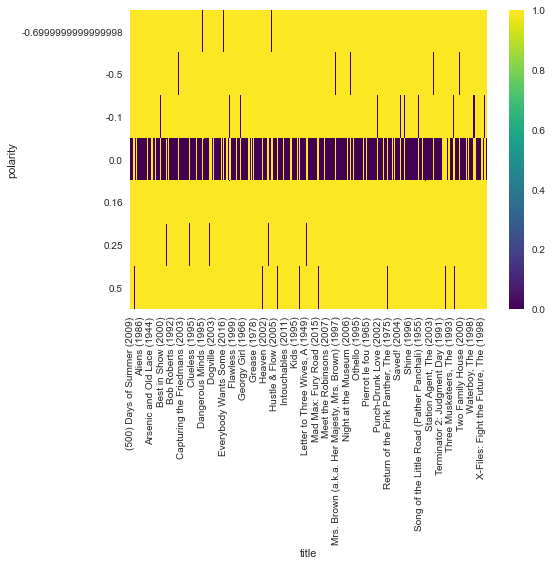

In [29]:
import seaborn as sns
sns.heatmap(movie_rp_pivot.isnull(),cmap='viridis')
plt.show()

#### Pivot Table Findings

I know I did this wrong because reading the table is unclear. Instead, would try again with different features as part of the table. 

## Bag of Words 

Bag of words turns text into numerical feature vector. It describes the word occurance. 



Here I created a bag of words from 
https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/

I performed vectorization with help from 
http://brandonrose.org/clustering#K-means-clustering and https://pythonprogramminglanguage.com/kmeans-text-clustering/

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(movies['tag'])
print(X.toarray())
X

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<1554x1742 sparse matrix of type '<class 'numpy.int64'>'
	with 5210 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.cluster import KMeans
num_clusters = 10
km_bag = KMeans(n_clusters=num_clusters)
model_bag = km_bag.fit(X)

clusters = km_bag.labels_.tolist()
y_pred = km_bag.fit_predict(X)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

`X3 = (movies['rating'].values,X)
print(X3.toarray())`

In [33]:
order_centroids = km_bag.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 comedy
 dark
 black
 humor
 coen
 brothers
 quirky
 twist
 great
 ending
Cluster 1:
 comedy
 and
 atmospheric
 superhero
 disney
 funny
 religion
 bad
 visually
 crime
Cluster 2:
 violence
 dialogue
 soundtrack
 film
 cult
 great
 tarantino
 nonlinear
 noir
 crime
Cluster 3:
 war
 world
 ii
 civil
 cold
 journalism
 fi
 sniper
 nuclear
 europe
Cluster 4:
 corruption
 police
 crime
 reno
 assassin
 hit
 men
 jean
 oldman
 quirky
Cluster 5:
 movie
 business
 animal
 show
 animation
 corruption
 good
 oscar
 politics
 music
Cluster 6:
 in
 queue
 netflix
 movie
 black
 dialogue
 robert
 samurai
 up
 hayao
Cluster 7:
 space
 effects
 slow
 visual
 soundtrack
 surreal
 meditative
 philosophical
 ship
 masterpiece
Cluster 8:
 ending
 twist
 fi
 sci
 provoking
 travel
 thought
 mindfuck
 time
 atmospheric
Cluster 9:
 sci
 space
 fi
 classic
 epic
 action
 adventure
 wars
 star
 goodie


In [34]:
kmeans_bag = KMeans(n_clusters=10)
model = kmeans_rp_2.fit_predict(X_rp)
model2 = kmeans_rp_2.fit(X_rp)

I used the same `KMeans` techniques here and if I was going to proceed I would need to map each title to the cluster it belongs to based on tag. This is something to do as part of future work. 